In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic = pd.read_csv('data/titanic_clean.csv')

In [3]:
titanic.head()

,Passengerid,Pclass,Survived,Sex,Age,Sibsp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,1,female,29.0000,0,0,24160,211.3375,B5,S
1,2,1,1,male,0.9167,1,2,113781,151.5500,C22 C26,S
2,3,1,0,female,2.0000,1,2,113781,151.5500,C22 C26,S
3,4,1,0,male,30.0000,1,2,113781,151.5500,C22 C26,S
4,5,1,0,female,25.0000,1,2,113781,151.5500,C22 C26,S


## Exploratory Data Analysis

In [4]:
titanic.isna().sum()

Passengerid       0
Pclass            0
Survived          0
Sex               0
Age             263
Sibsp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
titanic.corr()

,Passengerid,Pclass,Survived,Age,Sibsp,Parch,Fare
Passengerid,1.000000,0.897822,-0.293717,-0.343888,0.065594,0.003584,-0.481215
Pclass,0.897822,1.000000,-0.312469,-0.408106,0.060832,0.018322,-0.558629
Survived,-0.293717,-0.312469,1.000000,-0.055513,-0.027825,0.082660,0.244265
Age,-0.343888,-0.408106,-0.055513,1.000000,-0.243699,-0.150917,0.178739
Sibsp,0.065594,0.060832,-0.027825,-0.243699,1.000000,0.373587,0.160238
Parch,0.003584,0.018322,0.082660,-0.150917,0.373587,1.000000,0.221539
Fare,-0.481215,-0.558629,0.244265,0.178739,0.160238,0.221539,1.000000


In [6]:
titanic.describe()

,Passengerid,Pclass,Survived,Age,Sibsp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,378.020061,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,328.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passengerid  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Survived     1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   Sibsp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


In [8]:
#upper_outlier = train_df.Fare.quantile(0.95)
#train_data = train_df[train_df.Fare < upper_outlier].copy()

## Handling missing values for age and fare

In [9]:
titanic.Age.fillna(titanic.groupby(['Pclass']).Age.transform('mean'), inplace = True)

In [10]:
sum(titanic.Age.isna())

0

In [11]:
titanic.Fare.fillna(titanic.groupby(['Pclass']).Fare.transform('mean'), inplace = True)

In [12]:
sum(titanic.Fare.isna())

0

## Handling missing values in Cabin-column by dropping the whole column

In [13]:
titanic.drop(columns=['Cabin'], inplace = True)

## Feature engineering

# Implementing logistic regression from scratch

In [14]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [15]:
def calculate_loss(Y, y_hat, theta, lmbda=0):
    """Calculates the binary cross entropy loss"""
    m = len(Y)
    
    loss = (-1/m)*np.sum((Y*np.log(y_hat)) + (1-Y)*np.log(1-y_hat))

    if lmbda:
        loss = loss + np.squeeze((lmbda/2/m)*np.dot(theta.T, theta))
    
    return loss

In [16]:
def gradient_descent(X, Y, num_iterations=50000, learning_rate=0.001, lmbda=0, plot_cost=True):
    X = np.vstack([np.ones(X.shape[0]), X.T])
    theta = np.zeros(X.shape[0]).reshape(-1, 1) # initializing weights and bias
    m = len(Y)
    costs = []
    
    y_hat = sigmoid(np.dot(X.T, theta))
    
    for i in range(num_iterations):
        theta = theta - learning_rate*((1/m)*np.dot(X, (y_hat-Y)) + (lmbda/m)*theta)
        y_hat = sigmoid(np.dot(X.T, theta))
        cost = calculate_loss(Y, y_hat, theta, lmbda)
        
        if plot_cost and i % 1000 == 0:
            print(f'The cost at iteration {i} is {cost}')
        if plot_cost and i % 10 == 0:
            costs.append(cost)
    
    if plot_cost:
        plt.plot(costs)
        plt.xlabel('Number of iterations (per tenth)')
        plt.ylabel('Cost')
        plt.title('Learning rate = ' + str(learning_rate))
    
    return y_hat, theta, cost

In [17]:
def predict(X, model, decision_boundary=0.5):
    X = np.vstack([np.ones(X.shape[0]), X.T])
    y_hat = sigmoid(np.dot(X.T, model))
    return np.where(y_hat > decision_boundary, 1, 0)

In [18]:
def score():
    pass

# Training the model

In [57]:
y = titanic['Survived'].values.reshape(-1,1)
dummies = pd.get_dummies(titanic[['Pclass', 'Sex', 'Embarked']], drop_first=True)
X = pd.concat([dummies, titanic[['Age', 'Fare', 'Sibsp', 'Parch']]], axis=1).values

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((916, 8), (393, 8), (916, 1), (393, 1))

In [61]:
X_train.shape

(916, 8)

In [40]:
from logistic_regression import LogisticRegression

In [41]:
model = LogisticRegression()

The cost at iteration 0 is 0.67520348443258
The cost at iteration 1000 is 0.5964269753043472
The cost at iteration 2000 is 0.5817143760837105
The cost at iteration 3000 is 0.5722363015743354
The cost at iteration 4000 is 0.56485132317311
The cost at iteration 5000 is 0.5585613284923403
The cost at iteration 6000 is 0.5530008312145671
The cost at iteration 7000 is 0.5480060813516939
The cost at iteration 8000 is 0.5434844789310971
The cost at iteration 9000 is 0.5393725192688874
The cost at iteration 10000 is 0.5356211791286176
The cost at iteration 11000 is 0.5321902167578416
The cost at iteration 12000 is 0.5290455507367153
The cost at iteration 13000 is 0.52615781096106
The cost at iteration 14000 is 0.5235014052929315
The cost at iteration 15000 is 0.5210538552983381
The cost at iteration 16000 is 0.5187952952554111
The cost at iteration 17000 is 0.5167080810305872
The cost at iteration 18000 is 0.5147764775761347
The cost at iteration 19000 is 0.5129864047666016
The cost at iterati

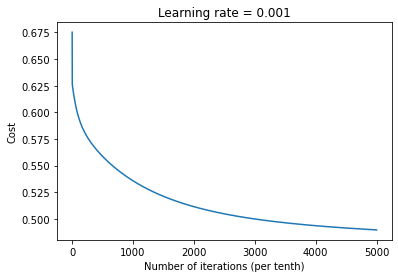

In [43]:
model.fit(X_train, y_train)

In [46]:
predictions = model.predict(X_test)

In [47]:
model.score(y_test, predictions)

78.11704834605598 % accuracy


## Comparing my model with a simple model that predicts survival for females/death for males

In [31]:
base_rate_sex_model = titanic.Sex.map({'male':0, 'female':1})

In [32]:
print(classification_report(titanic.Survived, base_rate_sex_model))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       809
           1       0.73      0.68      0.70       500

    accuracy                           0.78      1309
   macro avg       0.77      0.76      0.76      1309
weighted avg       0.78      0.78      0.78      1309



In [48]:
base_model_accuracy = accuracy_score(titanic.Survived, base_rate_sex_model)

In [50]:
base_model_accuracy

0.7799847211611918

In [52]:
from sklearn.linear_model import LogisticRegression as LR

In [53]:
hei = LR()

In [54]:
hei.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [ ]:
hei.predict()